# MicroSim2

- Counteless bug fixed
- Directed graph
- Agent tracks the edge information 
- Unification: cars can only enter edges through intersection
- Agents start with a virtual queue 
- Visualization (first time!) 



# Configureation

In [26]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
sns.set(font_scale=1.25,rc={"lines.linewidth": 2})
sns.set_style("white")
plt.rcParams['figure.figsize'] = [10, 8]

In [2]:
save_path = '/home/rewu/Documents/research/microsim/analysis/case_studies/test/'
tmp_path = '/tmp/tmp.t97Pt7Cago/'
save_interval = 1

config = {'NETWORK_PATH':'/home/rewu/Documents/research/microsim/analysis/test2/',
'OD_PATH' : '/home/rewu/Documents/research/microsim/analysis/test2/od.csv',
'START':'0',
'END':'100',
'SHOW_BENCHMARKS':'false',
'SAVE_PATH':save_path,
'SAVE_INTERVAL':str(save_interval)
}

In [3]:
network_config = {0:[[50,51],[0,50]],
                 1:[[50,51],[50,101]],
                 2:[[0,50],[50,51]],
                 3:[[50,101],[50,51]]}
network_size = 100
road_lengths = {0:50,1:50,2:50,3:50}
num_lanes = {0:2,1:1,2:1,3:1}

half_width = 2
colors = ['k', 'w', 'r', 'b', 'g','y','c','m']

In [4]:
def write_config_file(path, config):
    file_path = path + 'command_line_options.ini'
    with open(file_path, 'w') as f:
        f.write('[General]\n')
    
    
    with open(file_path, 'a') as the_file:
        for k,v in config.items():
            line = k + '=' + v +'\n'
            the_file.write(line)
    print ('write to ' + file_path)

In [5]:
write_config_file('./',config)

write to ./command_line_options.ini


# Post processing tools

In [6]:
def read_agent_file(save_path,time):
    agent_file = save_path+'agents_data_'+str(time)+'.csv'
    df = pd.read_csv(agent_file)
    return df

def read_edge_file(save_path,time):
    edge_file = save_path+'edge_data_'+str(time)+'.csv'
    df = pd.read_csv(edge_file)
    return df
    
def get_mean_speed():
    people_df = read_people_file(config['SAVE_PATH'])
    return people_df['avg_v(m/s)'].mean()
   

def mile2ms(mile):
    return 1.60934*mile*1000/3600



In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

 
def init_mtx(size):
    return np.zeros((size,size))-1

def init_road(mtx,row_interval,col_interval,num_lanes = 1, half_width = 2):
    
    if row_interval[1]-row_interval[0] > 1:
        start_col = col_interval[0] - (num_lanes//2)*2* half_width
        for i in range(num_lanes):
            mtx[row_interval[0]:row_interval[1],
                start_col-half_width:start_col+half_width+1] = 0
            start_col += 2* half_width
            
    else:
        start_row = row_interval[0] - (num_lanes//2)*2* half_width
        for i in range(num_lanes):
            mtx[start_row-half_width:start_row+half_width+1,
                col_interval[0]:col_interval[1]] = 0
            start_row += 2* half_width
        
    return mtx  


def set_lane(mtx,row_interval,col_interval,vals = np.array(1),half_width = 2):
    if row_interval[1]-row_interval[0] > 1:
        vals = vals.reshape(-1,1)
        mtx[row_interval[0]:row_interval[1],
            col_interval[0]-half_width:col_interval[1]+half_width] += vals
    else:
        mtx[row_interval[0]-half_width:row_interval[1]+half_width,
            col_interval[0]:col_interval[1]] += vals
    return mtx    



def select_agents(df,ori,dest):
    return df[(df['ori'] == ori) & 
              (df['dest'] == dest)&
              (df['status'] == 1)]

def assign_agents(df,mtx,agent_val):
    for eid in network_config.keys():
        l = road_lengths[eid]
        lanes = []
        for _ in range(num_lanes[eid]):
            lanes.append(np.zeros(l))
        agents = df[df['eid']==eid]
        if len(agents):
            for lane_id, pos in zip(agents['lane_number'],agents['pos']):
                lane = lanes[lane_id]
                lane[min(int(pos),l-1)] = agent_val
                
            row_interval,col_interval = network_config[eid]
            for i, lane in enumerate(lanes):
                if row_interval[1]-row_interval[0] > 1:
                    start_col = col_interval[0] - (len(lanes)//2)*2* half_width
                    start_col += 2* half_width*i
                    
                    mtx = set_lane(mtx,row_interval,[start_col,start_col+1],lane)
                else:
                    start_row = row_interval[0] - (len(lanes)//2)*2* half_width
                    start_row += 2* half_width*i
                    
                    mtx = set_lane(mtx,[start_row,start_row+1],col_interval,lane)
            
    return mtx

def plot_agents(df,mtx,ori,dst,val):
    selected_df = select_agents(df,ori,dst)
    mtx = assign_agents(selected_df,mtx,val)
    return mtx 

def plot_step(steps):
    mtx = init_mtx(network_size)
    for i, pos in network_config.items():
        mtx = init_road(mtx,pos[0],pos[1],num_lanes[i])
        
    df = agent_dfs[steps]
    for i, (ori,dst) in enumerate(od_list):
        plot_agents(df,mtx,ori,dst,i+1)
        mtx[i][0] = i+ 1 # for display purposes
#     print (mtx.max())
    mtx[mtx>i] = i + 1
    cmap = ListedColormap(colors[:2+len(od_list)])
    plt.matshow(mtx,cmap = cmap)

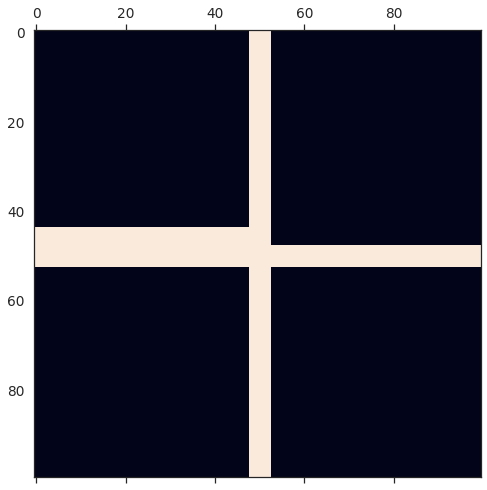

In [8]:
mtx = init_mtx(network_size)
for i, pos in network_config.items():
    mtx = init_road(mtx,pos[0],pos[1],num_lanes[i])
    
# cmap = ListedColormap(colors[:2+len(od_list)])
plt.matshow(mtx)

# Case One: Single route

In [ ]:
def uniform_od(o,d,start,interval,duration):
    num_agents = int(duration / interval)+1
    origins = [o]*num_agents
    dests = [d]*num_agents
    dep_time = np.linspace(start,start+duration,num_agents)
    
    df = {'origin':origins,
         'destination':dests,
         'dep_time':dep_time}
    
    return pd.DataFrame.from_dict(df)



In [503]:
interval = 1
duration = 20

od_list = [[0,4]]
od = uniform_od(0,4,0,interval,duration)

od.to_csv(config['NETWORK_PATH']+'od.csv',index=False)

In [504]:
!'/tmp/tmp.t97Pt7Cago/cmake-build-debug-office_server/microsim'

reading graph osm
total edges = 4
# of edges: 4
# of vertices: 5
Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 5
Setting CH edge vector of size 4
Range graph removed 0 edges of 8
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80%  100%
. 90% . 100% [TIME] Started: <Microsimulation_in_GPU>. 
Traffic person vec size = 21
EdgesData size = 5
LaneMap size = 10240
Intersections size = 5
GPU memory usage: used = 501, free = 10515 MB, total = 11016 MB
Running trafficSimulation with the following configuration:
>  Number of people: 21
>  Number of blocks: 1
>  Number of threads per block: 384
Running main loop from 0 to 0.0277778 with 21person... 
>>Simulation Ended


In [505]:
agent_dfs = []
for step in range(1,2*int(config['END'])):
    agent_dfs.append(read_agent_file(config['SAVE_PATH'],step))

In [506]:
interact(plot_step, steps=(0,150,1));

interactive(children=(IntSlider(value=75, description='steps', max=150), Output()), _dom_classes=('widget-inte…

In [14]:
agent_dfs[150]

,aid,ori,dest,type,status,travel_dist(m),travel_time(s),ave_speed(m/s),num_slowdown,num_lane_change,num_in_queue,v,delta_v,s,waited_steps,lane_number,eid,pos
0,0,0,4,0,2,100.0000,27.5,3.66390,36,0,0,3,0.764806,20,0,0,3,51.1532
1,1,0,4,0,2,100.0000,29.0,3.41921,27,0,1,3,0.764806,20,0,0,3,50.3851
2,2,0,4,0,2,100.0000,31.0,3.20654,30,0,1,3,0.764806,20,0,0,3,51.1123
3,3,0,4,0,2,100.0000,32.5,3.04882,30,0,1,3,0.764806,20,0,0,3,50.4510
4,4,0,4,0,2,100.0000,34.5,2.89480,35,0,1,3,0.764806,20,0,0,3,51.2423
5,5,0,4,0,2,100.0000,36.0,2.75003,34,1,2,3,0.764806,20,0,0,3,50.7385
6,6,0,4,0,2,100.0000,37.5,2.64363,37,1,0,3,0.764806,20,0,0,3,50.3702
7,7,0,4,0,2,100.0000,39.5,2.54201,35,0,4,3,0.764806,20,0,0,3,51.2909
8,8,0,4,0,2,100.0000,41.0,2.39520,39,1,3,3,0.764806,20,0,0,3,50.7233
9,9,0,4,0,2,100.0000,45.5,2.18397,43,3,7,3,0.764806,20,0,0,3,50.9022


# One origin two dests

In [507]:
interval = 1
duration = 10

od_list = [[0,4],[0,2]]
ods = [] 
for i, (o, d) in enumerate(od_list):
    ods.append(uniform_od(o,d,0,interval,duration))
    
od = pd.concat(ods)
od.to_csv(config['NETWORK_PATH']+'od.csv',index=False)


In [508]:
!'/tmp/tmp.t97Pt7Cago/cmake-build-debug-office_server/microsim'

reading graph osm
total edges = 4
# of edges: 4
# of vertices: 5
Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 5
Setting CH edge vector of size 4
Range graph removed 0 edges of 8
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80%  100%
. 90% . 100% [TIME] Started: <Microsimulation_in_GPU>. 
Traffic person vec size = 22
EdgesData size = 5
LaneMap size = 10240
Intersections size = 5
GPU memory usage: used = 501, free = 10515 MB, total = 11016 MB
Running trafficSimulation with the following configuration:
>  Number of people: 22
>  Number of blocks: 1
>  Number of threads per block: 384
Running main loop from 0 to 0.0277778 with 22person... 
>>Simulation Ended


In [509]:
agent_dfs = []
for step in range(1,2*int(config['END'])):
    agent_dfs.append(read_agent_file(config['SAVE_PATH'],step))

In [510]:
interact(plot_step, steps=(0,110,1));

interactive(children=(IntSlider(value=55, description='steps', max=110), Output()), _dom_classes=('widget-inte…

# Multi origs & dests

In [511]:
interval = 2
duration = 20

od_list = [[0,4],[0,2],[3,4],[3,2]]
ods = [] 
for i, (o, d) in enumerate(od_list):
    ods.append(uniform_od(o,d,i,interval,duration))
    
od = pd.concat(ods)
od.to_csv(config['NETWORK_PATH']+'od.csv',index=False)



In [512]:
!'/tmp/tmp.t97Pt7Cago/cmake-build-debug-office_server/microsim'

reading graph osm
total edges = 4
# of edges: 4
# of vertices: 5
Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 5
Setting CH edge vector of size 4
Range graph removed 0 edges of 8
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80%  100%
. 90% . 100% [TIME] Started: <Microsimulation_in_GPU>. 
Traffic person vec size = 44
EdgesData size = 5
LaneMap size = 10240
Intersections size = 5
GPU memory usage: used = 501, free = 10515 MB, total = 11016 MB
Running trafficSimulation with the following configuration:
>  Number of people: 44
>  Number of blocks: 1
>  Number of threads per block: 384
Running main loop from 0 to 0.0277778 with 44person... 
>>Simulation Ended


In [513]:
agent_dfs = []
for step in range(1,2*int(config['END'])):
    agent_dfs.append(read_agent_file(config['SAVE_PATH'],step))

In [514]:
interact(plot_step, steps=(0,150,1));

interactive(children=(IntSlider(value=75, description='steps', max=150), Output()), _dom_classes=('widget-inte…

# Super congestion 

In [524]:
interval = 1
duration = 10

od_list = [[0,4],[0,2],[3,4]
           ,[3,2],[1,4],[1,2]]
ods = [] 
for i, (o, d) in enumerate(od_list):
    ods.append(uniform_od(o,d,i,interval,duration))
    
od = pd.concat(ods)
od.to_csv(config['NETWORK_PATH']+'od.csv',index=False)


In [525]:
!'/tmp/tmp.t97Pt7Cago/cmake-build-debug-office_server/microsim'

reading graph osm
total edges = 4
# of edges: 4
# of vertices: 5
Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 5
Setting CH edge vector of size 4
Range graph removed 0 edges of 8
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80%  100%
. 90% . 100% [TIME] Started: <Microsimulation_in_GPU>. 
Traffic person vec size = 66
EdgesData size = 5
LaneMap size = 10240
Intersections size = 5
GPU memory usage: used = 500, free = 10516 MB, total = 11016 MB
Running trafficSimulation with the following configuration:
>  Number of people: 66
>  Number of blocks: 1
>  Number of threads per block: 384
Running main loop from 0 to 0.0277778 with 66person... 
>>Simulation Ended


In [526]:
agent_dfs = []
for step in range(1,2*int(config['END'])):
    agent_dfs.append(read_agent_file(config['SAVE_PATH'],step))

In [527]:
interact(plot_step, steps=(0,180,1));

interactive(children=(IntSlider(value=90, description='steps', max=180), Output()), _dom_classes=('widget-inte…

In [528]:
agent_dfs[22]

,aid,ori,dest,type,status,travel_dist(m),travel_time(s),ave_speed(m/s),num_slowdown,num_lane_change,...,delta_v,s,waited_steps,lane_number,eid,pos,intersection_id,q_id,route_ptr,edge_mid
0,0,0,4,0,1,50.0000,11.5,4.06585,0,0,...,-14.912200,20,5,0,0,50.9360,1,1,0,0
1,1,0,4,0,1,47.0098,10.5,4.08570,4,0,...,0.000000,1,0,0,0,47.0098,0,-1,0,0
2,2,0,4,0,1,39.6296,9.5,3.75133,2,1,...,0.000000,4,2,1,0,39.6296,0,-1,0,0
3,3,0,4,0,1,32.6816,8.5,3.39387,0,0,...,-0.275283,7,4,0,0,32.6816,0,-1,0,0
4,4,0,4,0,1,20.5657,7.5,2.26791,0,0,...,-0.385595,6,6,0,0,20.5657,0,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,61,1,2,0,1,0.0000,0.0,NaN,0,0,...,-10.000000,0,0,0,22011,-1.0000,1,-1,-1,96
62,62,1,2,0,0,0.0000,0.0,NaN,0,0,...,-10.000000,0,0,0,22011,-1.0000,-1,-1,-1,96
63,63,1,2,0,0,0.0000,0.0,NaN,0,0,...,-10.000000,0,0,0,22011,-1.0000,-1,-1,-1,96
64,64,1,2,0,0,0.0000,0.0,NaN,0,0,...,-10.000000,0,0,0,22011,-1.0000,-1,-1,-1,96


# Everyone start at the same time

In [529]:
interval = 0.01
duration = 1

od_list = [[0,4]]
ods = [] 
for i, (o, d) in enumerate(od_list):
    ods.append(uniform_od(o,d,i,interval,duration))
    
od = pd.concat(ods)
od.to_csv(config['NETWORK_PATH']+'od.csv',index=False)

od

,origin,destination,dep_time
0,0,4,0.00
1,0,4,0.01
2,0,4,0.02
3,0,4,0.03
4,0,4,0.04
...,...,...,...
96,0,4,0.96
97,0,4,0.97
98,0,4,0.98
99,0,4,0.99


In [530]:
!'/tmp/tmp.t97Pt7Cago/cmake-build-debug-office_server/microsim'

reading graph osm
total edges = 4
# of edges: 4
# of vertices: 5
Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 5
Setting CH edge vector of size 4
Range graph removed 0 edges of 8
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80%  100%
. 90% . 100% [TIME] Started: <Microsimulation_in_GPU>. 
Traffic person vec size = 101
EdgesData size = 5
LaneMap size = 10240
Intersections size = 5
GPU memory usage: used = 500, free = 10516 MB, total = 11016 MB
Running trafficSimulation with the following configuration:
>  Number of people: 101
>  Number of blocks: 1
>  Number of threads per block: 384
Running main loop from 0 to 0.0277778 with 101person... 
>>Simulation Ended


In [531]:
agent_dfs = []
for step in range(1,2*int(config['END'])):
    agent_dfs.append(read_agent_file(config['SAVE_PATH'],step))

In [532]:
interact(plot_step, steps=(0,180,1));

interactive(children=(IntSlider(value=90, description='steps', max=180), Output()), _dom_classes=('widget-inte…